In [1]:
import os
import json

from tqdm import tqdm
from tqdm import trange

import numpy as np
import pandas as pd

from scipy.stats import hypergeom
from scipy.stats import fisher_exact
from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize
from matplotlib import cm as cm_matplot
from matplotlib.colorbar import make_axes

import mygene

import sys
sys.path.insert(1, '../')
from utils import write_pickled_object, read_pickled_object, ModalitySelector

/nobackup/users/hmbaghda/Software/miniforge3/envs/metastatic_potential/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
data_path = '/nobackup/users/hmbaghda/metastatic_potential/'
random_state = 42 + 3

n_cores = 30
os.environ["OMP_NUM_THREADS"] = str(n_cores)
os.environ["MKL_NUM_THREADS"] = str(n_cores)
os.environ["OPENBLAS_NUM_THREADS"] = str(n_cores)
os.environ["VECLIB_MAXIMUM_THREADS"] = str(n_cores)
os.environ["NUMEXPR_NUM_THREADS"] = str(n_cores)

In [3]:
X = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'), index_col = 0)
expr_joint = X.copy()

mp_joint=pd.read_csv(os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), index_col = 0)['mean']
y = mp_joint.values.ravel()

expr_protein = pd.read_csv(os.path.join(data_path, 'processed',  'expr_protein.csv'), index_col = 0)
expr_rna = pd.read_csv(os.path.join(data_path, 'processed',  'expr.csv'), index_col = 0)

protein_cols = expr_protein.columns
rna_cols = expr_rna.columns

# with open("protein_cols.txt", "w") as f: f.writelines(f"{item}\n" for item in protein_cols)
# with open("rna_cols.txt", "w") as f: f.writelines(f"{item}\n" for item in rna_cols)


X_protein = X[protein_cols].values
X_rna = X[rna_cols].values

best_pipeline = read_pickled_object(os.path.join(data_path, 'processed', 
                                                 'best_model_svr_linear_joint.pickle'))


In [4]:
# fns = [os.path.join(data_path, 'processed', 
#                                                  'best_model_svr_linear_joint.pickle'), 
#        os.path.join(data_path, 'processed',  'expr_joint.csv'), 
#        os.path.join(data_path, 'processed', 'metastatic_potential_joint.csv'), 
#        os.path.join(data_path, 'processed',  'expr_protein.csv'), 
#        os.path.join(data_path, 'processed',  'expr.csv'), 
#       os.path.join(data_path, 'processed', 'uniprot_mapper.json')]

# print('scp hmbaghda@satori-login-002.mit.edu:' + ' hmbaghda@satori-login-002.mit.edu:'.join(fns) + ' Downloads/mp_ronit/.')
# # for fn in fns:
# #     print('scp hmbaghda@satori-login-002.mit.edu:' + fn + ' Downloads/mp_ronit')
# #     print(' ')

ID mapping between protein and RNA:

In [4]:
with open(os.path.join(data_path, 'processed', 'uniprot_mapper.json'), "r") as json_file:
    uid_mapper = json.load(json_file)
    
# manually mapped some that failed to map using uniprot ID
manual_map = {'Q9TNN7': 'HLA-C',
'P16189': 'HLA-A',
'P30456': 'HLA-A',
'P30443': 'HLA-A',
'P05534': 'HLA-A',
'P18462': 'HLA-A',
'P01892': 'HLA-A',
'P13746': 'HLA-A',
'P01891': 'HLA-A',
'P30483': 'HLA-B',
'P30484': 'HLA-B',
'P03989': 'HLA-B',
'P30460': 'HLA-B',
'P30461': 'HLA-B',
'Q95365': 'HLA-B',
'P16188': 'HLA-A',
'Q95604': 'HLA-C',
'Q07000': 'HLA-C',
'P30499': 'HLA-C',
'P30501': 'HLA-C',
'P30504': 'HLA-C',
'Q95IE3': 'HLA-DRB1',
'P04229': 'HLA-DRB1',
'P20039': 'HLA-DRB1',
'P13760': 'HLA-DRB1',
'Q5Y7A7': 'HLA-DRB1',
'Q9GIY3': 'HLA-DRB1',
'Q9TQE0': 'HLA-DRB1',
'Q30134': 'HLA-DRB1'}
    
protein_names = []
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names.append(gene_name)

In [5]:
rna_names = [rna_id.split(' (')[0] for rna_id in rna_cols]
# protein_names = [protein_id.split('|')[-1].split('_HUMAN')[0] for protein_id in protein_cols]
intersect_names = set(rna_names).intersection(protein_names)

n_features = [len(rna_names), len(protein_names), len(intersect_names)]
print('Of the {} RNA features and {} protein features, there are {} features in common'.format(*n_features))

Of the 19138 RNA features and 10969 protein features, there are 10291 features in common


Fit on the full dataset:

In [6]:
X = (X_protein, X_rna)
best_pipeline.fit(X, y)
model_coefs = best_pipeline.named_steps['model'].coef_.flatten()

# write_pickled_object(best_pipeline, 
#                      os.path.join(data_path, 'interim', 'best_linearSVR_joint_fitted_allsamples.pickle'))

/tmp/ipykernel_3915480/563516990.py:4: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'center')


''

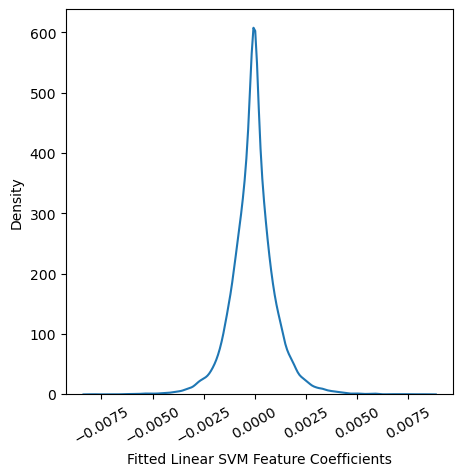

In [12]:
fig, ax = plt.subplots(figsize = (5,5))

sns.kdeplot(model_coefs, ax = ax)
ax.set_xticklabels(ax.get_xticklabels(), rotation = 30, ha = 'center')
ax.set_xlabel('Fitted Linear SVM Feature Coefficients')
# ax.set_title('Transcriptomics + Proteomics')

plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_dist.png'), 
            dpi=300, 
            bbox_inches="tight")  

;


Let's take a look at the top 500 features:

In [13]:
protein_indices = best_pipeline.named_steps['feature_processing'].transformer_list[0][1].named_steps['feature_selection_protein'].top_indices_
selected_protein_cols = [protein_cols[i] for i in protein_indices]

rna_indices = best_pipeline.named_steps['feature_processing'].transformer_list[1][1].named_steps['feature_selection_rna'].top_indices_
selected_rna_cols = [rna_cols[i] for i in rna_indices]

selected_cols = selected_protein_cols + selected_rna_cols

# X_selected = np.concatenate((X_protein[:,protein_indices], X_rna[:,rna_indices]),axis=1)
# np.savetxt(os.path.join(data_path, 'interim', 'joint_selected_X.txt'), 
#            X_selected, delimiter=',', fmt='%d')

model_coefs = best_pipeline.named_steps['model'].coef_.flatten()
model_coefs = pd.DataFrame(data = {'SVM coefficient': model_coefs, 
                                  'Modality': ['Proteomics']*len(selected_protein_cols) + ['Transcriptomics']*len(selected_rna_cols)}, 
                           index = selected_cols)

model_coefs_ = model_coefs.copy()
model_coefs_['feature_index'] = list(protein_indices) + list(rna_indices)
model_coefs_.reset_index(names = 'feature_name', inplace = True)


top_n = 500
model_coefs.sort_values(by='SVM coefficient', key=lambda x: x.abs(), ascending=False, inplace=True)
model_coefs.reset_index(names = 'Feature Name', inplace = True)
model_coefs['Modality'] = pd.Categorical(model_coefs['Modality'], 
                                         categories = ['Transcriptomics', 'Proteomics'], 
                                        ordered = True)
top_model_coefs = model_coefs.iloc[:top_n, :]

model_coefs.to_csv(os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'))

''

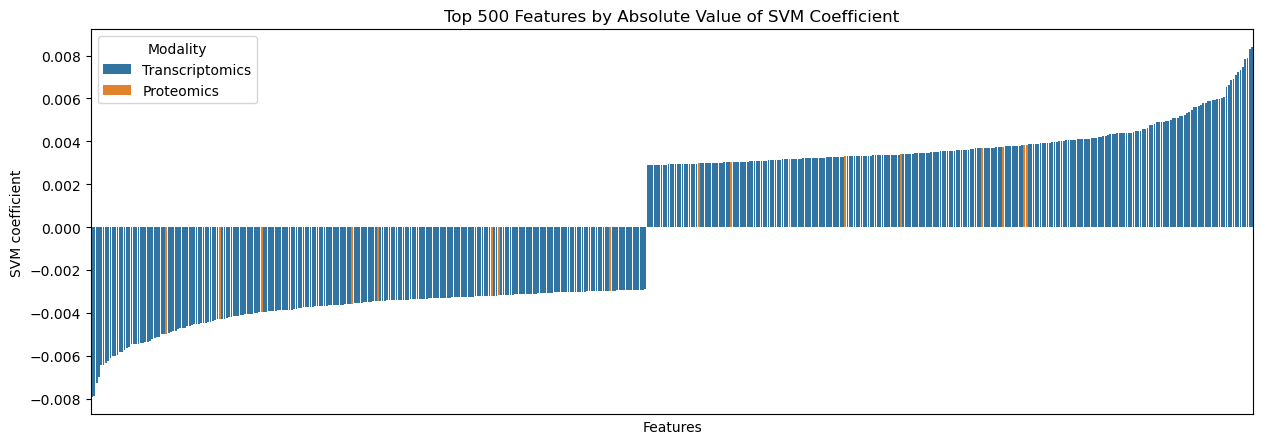

In [14]:
fig, ax = plt.subplots(figsize = (15, 5))

viz_df = top_model_coefs.sort_values(by = 'SVM coefficient', ascending = True)
sns.barplot(data = viz_df, x = 'Feature Name', y = 'SVM coefficient', hue = 'Modality', 
            ax = ax)
ax.set_xticklabels([])
ax.set_title('Top 500 Features by Absolute Value of SVM Coefficient')
ax.tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=False)
ax.set_xlabel('Features')

plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_top_barplot.png'), 
            dpi=300, 
            bbox_inches="tight")

;

Let's see how the top 5 features correlate with metastatic potential:

In [15]:
# possible features to generate null distribution from
# excluded top 500 features
expr_null = expr_joint[expr_joint.columns[~expr_joint.columns.isin(model_coefs.iloc[:500]['Feature Name'])]].copy()


In [16]:
model_coefs.head()

,Feature Name,SVM coefficient,Modality
0,RGS2 (5997),0.008402,Transcriptomics
1,MME (4311),0.008304,Transcriptomics
2,PI3 (5266),-0.007915,Transcriptomics
3,CSAG1 (158511),0.007863,Transcriptomics
4,IL32 (9235),-0.007855,Transcriptomics


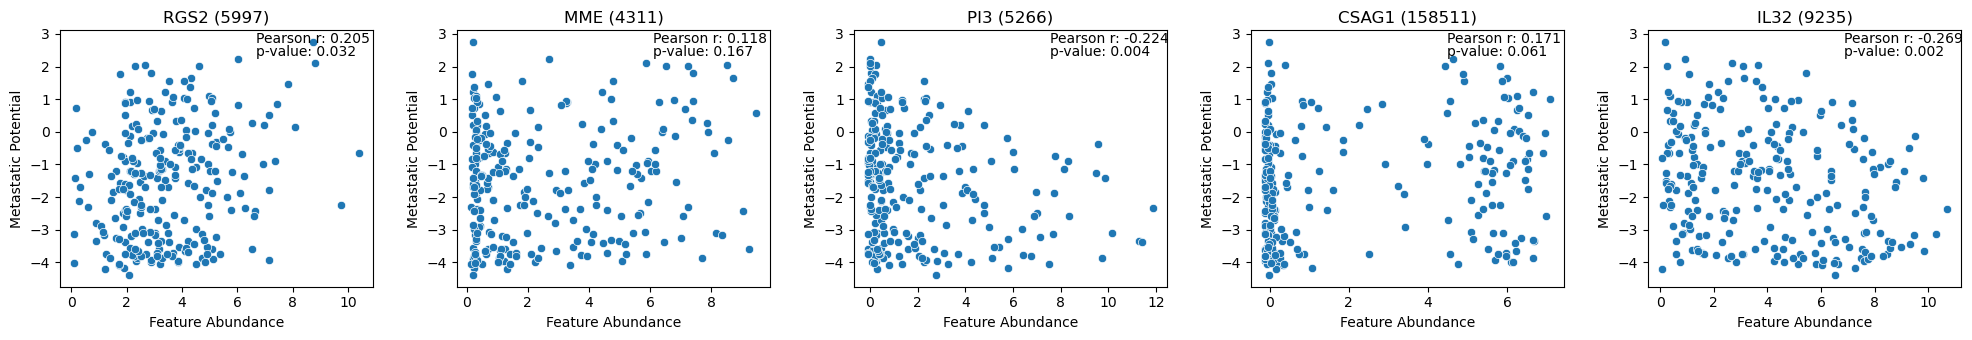

In [17]:
fig, ax = plt.subplots(ncols = 5, figsize = (20,3.5))

for i in range(5):
    # get pearson correlation between top feature and 
    fn = model_coefs.loc[i, 'Feature Name']
    pr = stats.pearsonr(expr_joint.loc[:, fn], 
                        mp_joint).statistic

    # get a null distribution of pearsons from a random subset of 1000 features in the dataframe
    np.random.seed(i)
    null_fn = np.random.choice(expr_null.columns, 1000, replace = False)
    null_pr = expr_joint.loc[:, null_fn].apply(lambda x: stats.pearsonr(x, mp_joint).statistic, axis = 0)

    # calculate the p-value (use absolut bc can be large negative or positive correlation)
    p_val = (100-stats.percentileofscore(null_pr.abs(), abs(pr), kind='rank'))/100

    sns.scatterplot(x = expr_joint.loc[:, fn], 
                   y = mp_joint, 
                   ax = ax[i])
    ax[i].annotate('Pearson r: {:.3f}'.format(pr), xy=(0.625, 0.95), xycoords='axes fraction')
    ax[i].annotate('p-value: {:.3f}'.format(p_val), xy=(0.625, 0.9), xycoords='axes fraction')
#     ax[i].set_xscale('log')
    ax[i].set_ylabel('Metastatic Potential')
    ax[i].set_xlabel('Feature Abundance')
    ax[i].set_title(fn)
#     ax[i].set_yscale('log')
#     ax[i].set_xscale('log')
fig.tight_layout()

Let's look at the relative usage of proteomics vs transcriptomic features:

In [18]:
def get_shared_genes(curr_coefs, get_prot_difference = False):
    rna_genes = set(curr_coefs[curr_coefs.Modality == 'Transcriptomics']['Gene Name'])
    protein_genes = set(curr_coefs[curr_coefs.Modality == 'Proteomics']['Gene Name'])
    common_genes = rna_genes.intersection(protein_genes)
    
    if get_prot_difference:
        diff_genes = protein_genes.difference(rna_genes)
        return rna_genes, protein_genes, common_genes, diff_genes
    
    return rna_genes, protein_genes, common_genes

In [19]:
# proteomics fraction

model_coefs['Protein Feature Fraction'] = np.nan
for i in trange(model_coefs.shape[0]):
    n_protein = model_coefs.iloc[:(i+1), :]['Modality'].value_counts()['Proteomics']    
    model_coefs.iloc[i, 3] = n_protein/(i+1)
    
model_coefs.reset_index(names = 'Feature Rank', inplace = True)
model_coefs['Feature Rank'] += 1

top_prot_feature = model_coefs.loc[model_coefs['Protein Feature Fraction'].idxmax(),'Feature Rank']

# shared features
rna_mapper = dict(zip(rna_cols, rna_names))
protein_mapper = dict(zip(protein_cols, protein_names))
gene_mapper = {**rna_mapper, **protein_mapper}
model_coefs['Gene Name'] = model_coefs['Feature Name'].map(gene_mapper)

model_coefs_['gene_name'] = model_coefs_['feature_name'].map(gene_mapper)
model_coefs_.to_csv(os.path.join(data_path, 'interim', 'joint_features.csv'))

model_coefs['Shared Genes Fraction - Protein'] = np.nan
model_coefs['Shared Genes Fraction - RNA'] = np.nan
for i in trange(model_coefs.shape[0]):
    curr_coefs=model_coefs.iloc[:(i+1), :]
    
#     rna_genes = set(curr_coefs[curr_coefs.Modality == 'Transcriptomics']['Gene Name'])
#     protein_genes = set(curr_coefs[curr_coefs.Modality == 'Proteomics']['Gene Name'])
#     common_genes = rna_genes.intersection(protein_genes)
    rna_genes, protein_genes, common_genes = get_shared_genes(curr_coefs)
    


    if len(protein_genes) != 0:
        model_coefs.iloc[i, 6] = len(common_genes)/len(protein_genes)
    else:
        model_coefs.iloc[i, 6] = 0
    model_coefs.iloc[i, 7] = len(common_genes)/len(rna_genes)

100%|██████████████████████████████████████████████████| 19638/19638 [01:17<00:00, 252.49it/s]


In [20]:
viz_df = model_coefs.copy()
viz_df['Unshared'] = 1- viz_df['Shared Genes Fraction - Protein']

# AB correlation

Next, let's get the correlation between protein and corresponding transcript:

This code was written by Arjana Begzati.

In [34]:
import scipy

In [ ]:
data_df = pd.read_csv(os.path.join(data_path, 'processed',  'expr_joint.csv'))
ranked_fts_df = model_coefs.copy()

In [22]:

protein_names_dict = {} 
for protein_id in protein_cols:
    uniprot_id = protein_id.split('|')[1].split('-')[0]
    if pd.isna(uid_mapper[uniprot_id]):
        gene_name = protein_id.split('|')[-1].split('_HUMAN')[0]
        if gene_name[0].isdigit():
            gene_name = manual_map[uniprot_id]
    else:
        gene_name = uid_mapper[uniprot_id]
    protein_names_dict[protein_id] = gene_name
    
rna_names_dict = {rna_id:rna_id.split(' (')[0] for rna_id in rna_cols}

assert list(ranked_fts_df['Modality'].unique())==['Transcriptomics', 'Proteomics']
ranked_fts_df['Gene Name'] = np.where(ranked_fts_df['Modality']=='Transcriptomics',
                                 ranked_fts_df['Feature Name'].map(rna_names_dict), 
                                 ranked_fts_df['Feature Name'].map(protein_names_dict))
assert sum(ranked_fts_df['Gene Name'].isna())==0

100%|███████████████████████████████████████████████| 10969/10969 [00:00<00:00, 325584.16it/s]


In [23]:
# number of proteins
len(ranked_fts_df[ranked_fts_df['Modality']=='Proteomics']['Feature Name'].to_list())

500

In [24]:
# number of proteins with rna feature
ranked_fts_subdf = ranked_fts_df.groupby('Gene Name').filter(lambda g: 
                                                      {'Transcriptomics', 'Proteomics'}.issubset(set(g['Modality'])))
print(ranked_fts_subdf.shape[0])
prots_in_rankedfts_w_rna = ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']['Feature Name'].to_list()
len(prots_in_rankedfts_w_rna)

987


494

In [25]:
ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']['Gene Name'].nunique()

493

In [26]:
# (2*493) + 1, bc 1 gene has 2 prots
ranked_fts_prot_subdf = ranked_fts_subdf[ranked_fts_subdf['Modality']=='Proteomics']
ranked_fts_prot_subdf[ranked_fts_prot_subdf.duplicated(subset=['Modality', 'Gene Name'], keep=False)]

,Feature Rank,Feature Name,SVM coefficient,Modality,Protein Feature Fraction,Gene Name,Shared Genes Fraction - Protein,Shared Genes Fraction - RNA
3347,3348,sp|P07951|TPM2_HUMAN,-0.001350,Proteomics,0.029271,TPM2,0.357143,0.010769
4711,4712,sp|P07951-2|TPM2_HUMAN,0.001099,Proteomics,0.031197,TPM2,0.417808,0.013363


In [27]:
ranked_fts_df[ranked_fts_df['Gene Name']=='TPM2']
# below: since transcript is not in top_n rank until after both proteins, 
    # only encountered scenarios includes both pairs being in non-overlapping or overlapping set (feeding into that mean)

,Feature Rank,Feature Name,SVM coefficient,Modality,Protein Feature Fraction,Gene Name,Shared Genes Fraction - Protein,Shared Genes Fraction - RNA
3347,3348,sp|P07951|TPM2_HUMAN,-0.001350,Proteomics,0.029271,TPM2,0.357143,0.010769
4711,4712,sp|P07951-2|TPM2_HUMAN,0.001099,Proteomics,0.031197,TPM2,0.417808,0.013363
14888,14889,TPM2 (7169),-0.000193,Transcriptomics,0.028679,TPM2,0.802817,0.023648


In [38]:
def calc_corr(values_df, ft1, ft2, corr_type):
    if corr_type=='pearson':
        r, p = scipy.stats.pearsonr(values_df.loc[:,ft1].values, values_df.loc[:,ft2].values)
    elif corr_type=='spearman':
        r, p = scipy.stats.spearmanr(values_df.loc[:,ft1].values, values_df.loc[:,ft2].values)
    else: raise('choose pearson or spearman')
    return r,p

def calc_overlapping_vs_not_mean_correlations(top_n, cor_df, cor_col):
    top_n_fts_df = ranked_fts_df.iloc[:top_n, :]
    
    rna_genes = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Transcriptomics']['Gene Name'])
    protein_genes = set(top_n_fts_df[top_n_fts_df['Modality'] == 'Proteomics']['Gene Name'])
    
    common_genes = protein_genes.intersection(rna_genes)
    only_prot_genes = protein_genes.difference(rna_genes)
    
    numb_overlapping_genes = len(common_genes)
    numb_nonoverlapping_genes = len(only_prot_genes)
    
    overlapping_cor_df = cor_df[cor_df['Gene Name'].isin(common_genes)]
    nonoverlapping_cor_df = cor_df[cor_df['Gene Name'].isin(only_prot_genes)]
    
    if overlapping_cor_df.shape[0]>0:
        mean_overlapping_cor = overlapping_cor_df[cor_col].mean()
    else: 
        mean_overlapping_cor = np.nan
    if nonoverlapping_cor_df.shape[0]>0:
        mean_nonoverlapping_cor = nonoverlapping_cor_df[cor_col].mean()
    else: 
        mean_nonoverlapping_cor = np.nan
    return top_n, numb_overlapping_genes, mean_overlapping_cor, numb_nonoverlapping_genes, mean_nonoverlapping_cor

Get correlation between features:

In [35]:
pearson_corr_df = pd.DataFrame(columns=['prot_ft', 'rna_ft', 'r', 'p'])
for prot_ft in tqdm(prots_in_rankedfts_w_rna):
    rna_df = ranked_fts_df[(ranked_fts_df['Gene Name']==protein_names_dict[prot_ft]) & 
                           (ranked_fts_df['Modality']=='Transcriptomics')]
    assert rna_df.shape[0]==1
    rna_ft = rna_df['Feature Name'].values[0]
    r, p = calc_corr(values_df=data_df, ft1=prot_ft, ft2=rna_ft, corr_type='pearson')
    new_row = pd.DataFrame({'prot_ft': [prot_ft],  'rna_ft':[rna_ft], 'r': [r], 'p': [p]})
    pearson_corr_df = pd.concat([pearson_corr_df, new_row], ignore_index=True)
pearson_corr_df['Gene Name'] = pearson_corr_df['rna_ft'].map(rna_names_dict)

  0%|                                                                 | 0/494 [00:00<?, ?it/s]/tmp/ipykernel_3915480/848491727.py:9: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  pearson_corr_df = pd.concat([pearson_corr_df, new_row], ignore_index=True)
100%|██████████████████████████████████████████████████████| 494/494 [00:02<00:00, 214.69it/s]


(494, 4)

Split correlation as a rank order between overlapping and not:

In [39]:
ranked_split_mean_pearson_corr_df = pd.DataFrame(columns=['Feature Rank', 
                                                          'Number of Overlapping Genes', 
                                                          'Overlapping Mean Pearson Correlation', 
                                                          'Number of Non-overlapping Genes',
                                                          'Non-overlapping Mean Pearson Correlation'])

for rank in tqdm(range(1, ranked_fts_df.shape[0]+1)):
    top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor = calc_overlapping_vs_not_mean_correlations(
                                                                        top_n=rank, cor_df=pearson_corr_df, cor_col='r') 
    ranked_split_mean_pearson_corr_df = pd.concat([ranked_split_mean_pearson_corr_df, 
                                                   pd.DataFrame(
                                                       [[top_n, numb_o_genes, mean_o_cor, numb_no_genes, mean_no_cor]], 
                                                        columns=ranked_split_mean_pearson_corr_df.columns)], 
                                                   ignore_index=True)
corr_rank = ranked_split_mean_pearson_corr_df.copy()

  0%|                                                     | 36/19638 [00:00<00:54, 357.08it/s]/tmp/ipykernel_3915480/2662520364.py:10: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  ranked_split_mean_pearson_corr_df = pd.concat([ranked_split_mean_pearson_corr_df,
100%|██████████████████████████████████████████████████| 19638/19638 [01:43<00:00, 189.01it/s]


(19638, 5)

In [59]:
corr_rank['Difference'] = corr_rank['Overlapping Mean Pearson Correlation'] - corr_rank['Non-overlapping Mean Pearson Correlation']
corr_rank['Normalized_Difference'] = corr_rank.Difference/corr_rank['Difference'].mean()

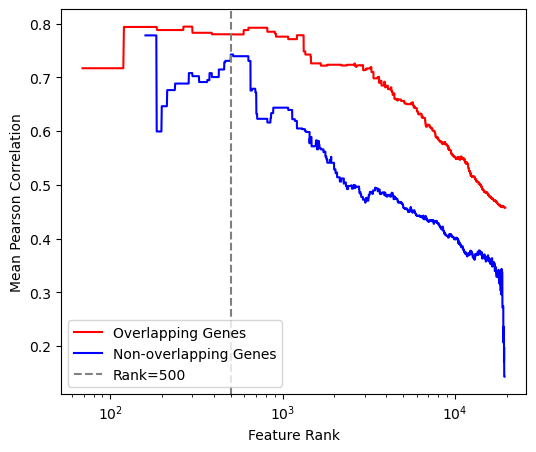

In [60]:
fig, ax = plt.subplots(figsize = (6,5))
sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Overlapping Mean Pearson Correlation',
             color='red', label='Overlapping Genes')
sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Non-overlapping Mean Pearson Correlation',
             color='blue', label='Non-overlapping Genes')
ax.axvline(x=500, color='grey', linestyle='--', label='Rank=500')
ax.set_ylabel('Mean Pearson Correlation')
ax.set_xscale('log')
ax.legend();

plt.savefig(os.path.join(data_path, 'figures', 'overlapping_pearson_running_rank.png'), 
            dpi=300, 
            bbox_inches="tight")

/tmp/ipykernel_3915480/1746507043.py:31: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  ax[2].set_xlim(xmin, xmax)


''

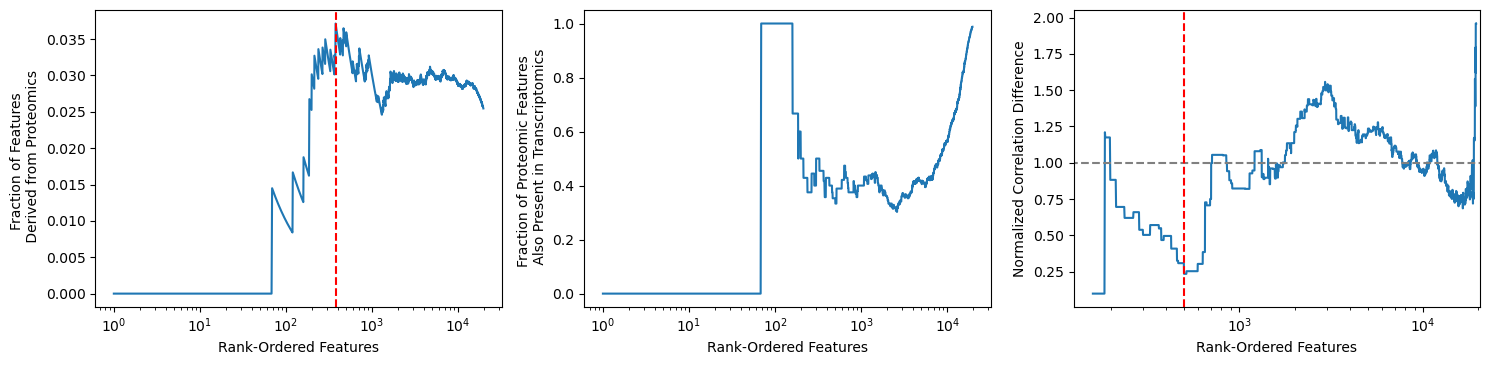

In [61]:
fig, ax = plt.subplots(figsize = (15, 3.75), ncols = 3)

sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Protein Feature Fraction', 
            ax = ax[0])
ax[0].set_xlabel('Rank-Ordered Features')
ax[0].set_xscale('log')
ax[0].set_ylabel('Fraction of Features \n Derived from Proteomics')
ax[0].axvline(x=top_prot_feature, color='red', linestyle='--')


sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Shared Genes Fraction - Protein', 
             ax = ax[1])
ax[1].set_xlabel('Rank-Ordered Features')
ax[1].set_xscale('log')
ax[1].set_ylabel('Fraction of Proteomic Features \n Also Present in Transcriptomics')


# sns.lineplot(data = model_coefs, x = 'Feature Rank', y = 'Shared Genes Fraction - RNA', 
#              ax = ax[2])
# ax[2].set_xlabel('Rank-Ordered Features')
# ax[2].set_xscale('log')
# ax[2].set_ylabel('Fraction of Transcriptomic Features \n Also Present in Proteomics')

sns.lineplot(data = corr_rank, x = 'Feature Rank', y = 'Normalized_Difference', ax = ax[2])
xmin, xmax = ax[2].get_xlim()
ymin, ymax = ax[2].get_ylim()
ax[2].hlines(1, xmin = xmin, xmax = xmax, color = 'gray', linestyle = '--')
ax[2].vlines(500, ymin = ymin, ymax = ymax, color = 'red', linestyle = '--')
ax[2].set_xscale('log')

ax[2].set_xlim(xmin, xmax)
ax[2].set_ylim(ymin, ymax)
ax[2].set_ylabel('Normalized Correlation Difference')
ax[2].set_xlabel('Rank-Ordered Features')


fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_running_rank.png'), 
            dpi=300, 
            bbox_inches="tight")

;

In [20]:
msg = 'Whereas all {} RNA features were selected in the model, '.format(len(selected_rna_cols))
msg += 'only {} of the protein features were selected'.format(len(selected_protein_cols))
protein_frac_all = 100*len(selected_protein_cols)/len(selected_cols)
msg += '. Thus, protein features comprise {:.2f}% of all features used in the model'.format(protein_frac_all) 

protein_frac = 100*model_coefs[model_coefs['Feature Rank'] == top_n]['Protein Feature Fraction'].tolist()[0]
msg +='. They comprise {:.2f}% of the top 500 features'.format(protein_frac)

print(msg)
print('')
print('The fraction of features derived from protein peaks at the top {} feature at {:.2f}%'.format(top_prot_feature, 100 * model_coefs['Protein Feature Fraction'].max()))




Whereas all 19138 RNA features were selected in the model, only 500 of the protein features were selected. Thus, protein features comprise 2.55% of all features used in the model. They comprise 3.40% of the top 500 features

The fraction of features derived from protein peaks at the top 377 feature at 3.71%


Regarding the first panel, this suggests a weighting of proteomics in the top features, which aligns with the fact that they help improve predictive performance.

In [21]:
all_features_shared_prot = 100*model_coefs['Shared Genes Fraction - Protein'].tolist()[-1]
top_n_shared_prot = 100*model_coefs[model_coefs['Feature Rank'] == top_n]['Shared Genes Fraction - Protein'].tolist()[0]
max_frac_shared_prot = 100*model_coefs[model_coefs['Feature Rank'] == top_prot_feature]['Shared Genes Fraction - Protein'].tolist()[0]
all_shared_prot = [all_features_shared_prot, top_n_shared_prot, max_frac_shared_prot]

msg = 'The percent of proteomics features that are in common with transcriptomics is'
msg += ' {:.2f}%, {:.2f}%, {:.2f}%'.format(*all_shared_prot)
msg += ' for all features used by the model, the top 500 features, '
msg += 'and the top {} features (where the fraction of features that is dervied from proteomics is maximized)'.format(top_prot_feature)
msg += ' , respectively.'
print(msg)


The percent of proteomics features that are in common with transcriptomics is 98.80%, 35.29%, 35.71% for all features used by the model, the top 500 features, and the top 377 features (where the fraction of features that is dervied from proteomics is maximized) , respectively.


Regarding the second panel, this tells us that while features representing the same gene between transcriptomics and proteomics do add information,they are substantially less heavily favored in the more influential set of top-ranked features (fewer features are shared in the top 500 than in all features used in the dataset).

Let's quantitate this using over-representation analysis:

For the fraction of proteomics, we can test whether there is an enrichment of proteomic features in the top 500 features. A contingency matrix testing for enrichment of Pathway A in a gene list will look as follows:

enrichment of missing/imputed values for the under-predicted genes. 

|                   | In Pathway A               | Not in Pathway A               |
|-------------------|----------------------------|--------------------------------|
| Pathway A         | Count of genes in both       | Count of genes in "Pathway A"  |
|                   | "Pathway A" and your gene    | but not in your gene list      |
|                   | list (observed)             | (expected under null hypothesis)|
|-------------------|----------------------------|--------------------------------|
| Not Pathway A     | Count of genes not in        | Count of genes not in          |
|                   | "Pathway A" but in your      | "Pathway A" and not in your     |
|                   | gene list (observed)         | gene list (expected under null  |
|                   |                            | hypothesis)                     |

Here we test for over-representation of the proteomic modality in the top ranked features:

| Modality            | Top *n* Features | Outside Top *n* | Total |
|---------------------|------------------|-----------------|-------|
| Proteomics          | a                | b               | a + b |
| Transcriptomics     | c                | d               | c + d |
| Total               | a + c            | b + d           | N     |


- a: Proteomic features within the top n ranks.
- b: Proteomic features outside the top n ranks.
- c: Transcriptomic features within the top n ranks.
- d: Transcriptomic features outside the top n ranks.


We also test for depletion of proteomic features that have a transcriptomic counterpart:
| Proteomic features  | Top *n* Features | Outside Top *n* | Total |
|---------------------|------------------|-----------------|-------|
| Overlapping         | a                | b               | a + b |
| Non-overlapping     | c                | d               | c + d |
| Total               | a + c            | b + d           | N     |


- a: Proteomic features overlapping with transcriptomic features within the top n ranks.
- b: Proteomic features overlapping with transcriptomic features outside the top n ranks.
- c: Proteomic features not overlapping with transcriptomic features within the top n ranks.
- d: Proteomic features not overlapping with transcriptomic features outside the top n ranks.


In [22]:
def proteomic_ora(model_coefs, n, verbose = False):
    # Define contingency table
    top_n = model_coefs[model_coefs["Feature Rank"] <= n]
    outside_top_n = model_coefs[model_coefs["Feature Rank"] > n]
    
    # Calculate counts for contingency table
    a = (top_n["Modality"] == "Proteomics").sum() # proteomic features in top n
    c = (top_n["Modality"] == "Transcriptomics").sum() 
    b = (outside_top_n["Modality"] == "Proteomics").sum()
    d = (outside_top_n["Modality"] == "Transcriptomics").sum()
    
    N = model_coefs.shape[0] # total features
    K = a + b # total number of protein features
    k = a # total number of protein features in top n
    
#     hypergeom_p = hypergeom(M=N, n=K, N=n).sf(k-1)
    
    # Calculate odds ratio
    odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]], alternative = 'greater')
    if verbose: 
        msg = 'At a feature rank of {}'.format(n)
        msg += " the Fisher's exact test p-value for over-representation of proteomic features is"
        msg += " {:.3f}, with an odds ratio of {:.2f}".format(fisher_p, odds_ratio)
        print(msg)
    else: 
        return odds_ratio, fisher_p#, hypergeom_p
    
    
# def shared_ora(model_coefs, n, verbose = False):
#     # Define contingency table
#     top_n = model_coefs[model_coefs["Feature Rank"] <= n]
#     outside_top_n = model_coefs[model_coefs["Feature Rank"] > n]
    
#     _, prot_genes_top, common_genes_top, diff_genes_top = get_shared_genes(top_n, get_prot_difference = True)
#     _, prot_genes_out, common_genes_out, diff_genes_out = get_shared_genes(outside_top_n, get_prot_difference = True)

    
#     # Calculate counts for contingency table
#     a = len(diff_genes_top)
#     c = len(common_genes_top)
#     b = len(diff_genes_out)
#     d = len(common_genes_out)

#     # Calculate odds ratio
#     odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]], alternative = 'greater')

    
#     if verbose: 
#         msg = 'At a feature rank of {}'.format(n)
#         msg += " the Fisher's exact test p-value for over-representation of proteomic features that"
#         msg += " are not shared with transcriptomic features is"
#         msg += " {:.3e}, with an odds ratio of {:.2f}".format(fisher_p, odds_ratio)
#         print(msg)
#     else: 
#         return odds_ratio, fisher_p#, hypergeom_p
    
    
    
def shared_ora(model_coefs, n, verbose = False):
    # Define contingency table
    top_n = model_coefs[model_coefs["Feature Rank"] <= n]
    outside_top_n = model_coefs[model_coefs["Feature Rank"] > n]
    
    _, prot_genes_top, common_genes_top, diff_genes_top = get_shared_genes(top_n, get_prot_difference = True)
    _, prot_genes_out, common_genes_out, diff_genes_out = get_shared_genes(outside_top_n, get_prot_difference = True)

    
    # Calculate counts for contingency table
    a = len(common_genes_top) 
    c = len(diff_genes_top)
    b = len(common_genes_out)
    d = len(diff_genes_out)

    # Calculate odds ratio
    odds_ratio, fisher_p = fisher_exact([[a, b], [c, d]], alternative = 'less')

    
    if verbose: 
        msg = 'At a feature rank of {}'.format(n)
        msg += " the Fisher's exact test p-value for depletion of proteomic features that"
        msg += " are shared with transcriptomic features is"
        msg += " {:.3e}, with an odds ratio of {:.2f}".format(fisher_p, odds_ratio)
        print(msg)
    else: 
        return odds_ratio, fisher_p
    

In [23]:
shared_ora(model_coefs, n = 500, verbose = True)

At a feature rank of 500 the Fisher's exact test p-value for depletion of proteomic features that are shared with transcriptomic features is 7.769e-11, with an odds ratio of 0.02


In [24]:
proteomic_ora(model_coefs, n = top_prot_feature, verbose = True)

At a feature rank of 377 the Fisher's exact test p-value for over-representation of proteomic features is 0.103, with an odds ratio of 1.49


In [25]:
proteomic_ora(model_coefs, n = 500, verbose = True)

At a feature rank of 500 the Fisher's exact test p-value for over-representation of proteomic features is 0.140, with an odds ratio of 1.36


In [53]:
ora_proteomics_res = pd.DataFrame(columns = ['rank', 'odds_ratio', 'fisher_exact_p'])#, 'hypergeometric_p'])
for i, n in enumerate(range(650, 500, -1)):
    ora_proteomics_res.loc[i, :] = [n] + list(proteomic_ora(model_coefs, n))
ora_proteomics_res['-log(p-value)'] = -np.log(ora_proteomics_res.fisher_exact_p.astype(float))
ora_proteomics_res['odds_ratio'] = ora_proteomics_res.odds_ratio.apply(lambda x: float(x))
ora_proteomics_res['rank'] = ora_proteomics_res['rank'].astype(int)

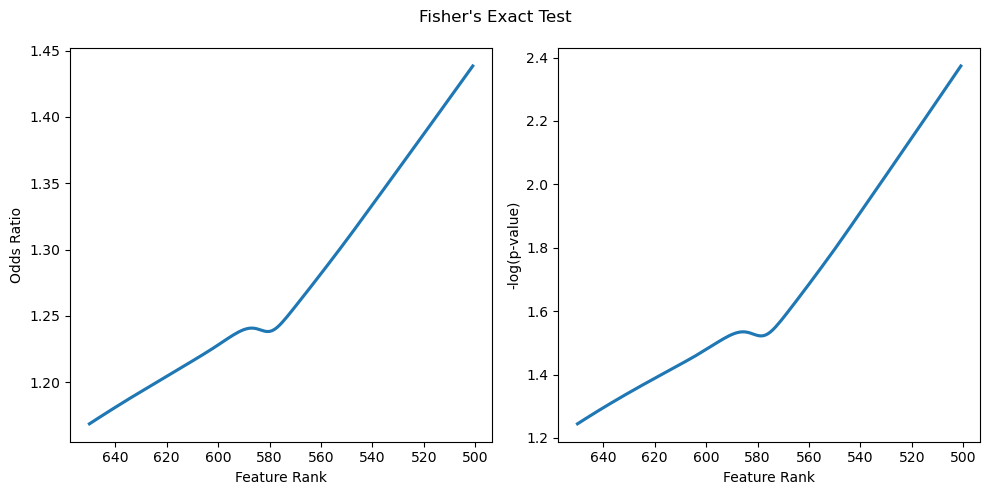

In [121]:
fig, ax = plt.subplots(ncols = 2, figsize = (10, 5))

# sns.scatterplot(data = ora_proteomics_res, x = 'rank', y = 'odds_ratio', 
#                 color = 'black',
#                 ax = ax[0])
sns.regplot(data = ora_proteomics_res, x = 'rank', y = 'odds_ratio', ci = None, 
            scatter = False, lowess = True, ax = ax[0])

ax[0].set_ylabel("Odds Ratio")
# sns.scatterplot(data = ora_proteomics_res, x = 'rank', y = '-log(p-value)', ax = ax[1])
sns.regplot(data = ora_proteomics_res, x = 'rank', y = '-log(p-value)', ci = None, 
            scatter = False, lowess = True, ax = ax[1])
# ax[1].axhline(y=-np.log(0.05), color='red', linestyle='dashed')


for i in range(2):
    ax[i].set_xlabel('Feature Rank')
    ax[i].invert_xaxis()
    

fig.suptitle("Fisher's Exact Test")
fig.tight_layout()
plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_fisher_trend.png'), 
            dpi=300, 
            bbox_inches="tight")

We can repeat this for the number of proteomic features shared with transcriptomic features:

Finally, let's look at how the features selected by the joint omics model compare to that of the transcriptomics only model. The one caveat in this comparison is that both models were fit to their entire respective dataset, which is 247 samples for the join omics model and 483 samples for the transcriptomics-only model.

# to do: comparison with transcriptomics
- use full dataset, or identify consensus features in transcriptomics of a sample subset of equal size?
- in the joint model when protein features are present that are not in common with transcriptomics features, are those transcriptomic features present in the transcriptomics only model? this tells us those genes are informative, but more i

In [48]:
# fns = [os.path.join(data_path, 'processed',  'expr_joint.csv'),
# os.path.join(data_path, 'processed', 'uniprot_mapper.json'),
# os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'),
# '/home/hmbaghda/Projects/metastatic_potential/notebooks/C_joint_prediction/*.txt']

# for fn in fns:
#     cmd = 'scp hmbaghda@satori-login-002.mit.edu:' + fn
#     cmd += ' Downloads/for_Arjana/.'
#     print(cmd)

## ORA

We will run ORA on the positive and negative coefficients from the top 500 features separately. 

In [55]:
top_model_coefs = model_coefs.iloc[:top_n].copy()
neg_top = top_model_coefs[top_model_coefs['SVM coefficient'] < 0]
pos_top = top_model_coefs[top_model_coefs['SVM coefficient'] > 0]

background = sorted(set(protein_names).union(rna_names))
fn_oras = []
# prepare for metascape input
for col_name, gene_list in {'negative': neg_top, 'positive': pos_top}.items():
    mi = pd.DataFrame(data = {'_BACKGROUND': background})

    goi = gene_list['Gene Name'].tolist()
    mi[col_name] = goi + [np.nan]*(len(background)- len(goi))
    
    mi.set_index('_BACKGROUND', inplace = True)
    
    fn_ora = os.path.join(data_path, 'interim/', col_name + '_joint_metascape_input.csv')
    fn_oras.append(fn_ora)
    mi.to_csv(fn_ora)

In [56]:
# for fn in fn_oras:
#     cmd = 'scp hmbaghda@satori-login-002.mit.edu:' + fn
#     cmd += ' Downloads/.'
#     print(cmd)

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/interim/negative_joint_metascape_input.csv Downloads/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/interim/positive_joint_metascape_input.csv Downloads/.


Load and format metascape output:

In [115]:
mss = {}
sort_by = 'pval' #'zscore'
for key in ['negative', 'positive']:
    ms = pd.read_excel(os.path.join(data_path, 'processed', key + '_joint_metascape_results.xlsx'), 
                           sheet_name = 'Enrichment',
                           index_col = None)
    ms_all = pd.read_csv(os.path.join(data_path, 'processed', key + '_joint_GO_AllLists.csv'), 
                        index_col = 0)

    # get average z-score per summary term from the individual members
    ms_members = ms[ms['GroupID'].apply(lambda x: x.endswith('_Member'))].copy()
    if ms_members.Term.nunique() != ms_members.shape[0]:
        raise ValueError('Expected unique terms')

    zscores = []
    for term in ms_members.Term:
        ms_term = ms_all[ms_all.GO == term]
        if ms_term.shape[0] > 1:
            raise ValueError('Expected 1 unique term')
        elif ms_term.shape[0] == 0:
            zscores.append(np.nan)
        else:
            zscores.append(ms_term['Z-score'].values.tolist()[0])
    ms_members['Z-score'] = zscores

    term_zscore = ms_members.groupby('GroupID')['Z-score'].mean().to_dict()
    term_zscore = {k.split('_')[0]:v for k,v in term_zscore.items()}

    ms = ms[ms['GroupID'].apply(lambda x: x.endswith('_Summary'))]
    ms.reset_index(drop = True, inplace = True)
    ms['Z-score'] = ms['GroupID'].apply(lambda x: term_zscore[x.split('_')[0]])
    
    
    # formatting
    ms['q-value'] = 10**ms['Log(q-value)']
    ms = ms[ms['q-value'] <= 0.1]
    ms['-Log10(q-value)'] = -ms['Log(q-value)']
    if ms['Z-score'].min() < 0:
        raise ValueError('Sorted according to assumption that all Z-scores to be positive')
    if sort_by == 'zscore':
        ms.sort_values(by = ['Z-score','Log(q-value)'], ascending=[False, True], inplace = True) 
    elif sort_by == 'pval':
        # sort by q-value, tie break with z-score
        ms.sort_values(by = ['Log(q-value)', 'Z-score'], ascending=[True, False], inplace = True) 
    else:
        raise ValueError('Specificy a sort column')

    ms.reset_index(drop = True, inplace = True)
    mss[key] = ms

In [116]:
def middle_break(my_string, len_thresh):
    if len(my_string) >= len_thresh:
        middle_index = len(my_string) // 2

        space_before = my_string.rfind(' ', 0, middle_index)  
        space_after = my_string.find(' ', middle_index)       

        # Choose the nearest space
        if space_before == -1:  
            break_index = space_after
        elif space_after == -1:  
            break_index = space_before
        else:  
            break_index = space_before if middle_index - space_before <= space_after - middle_index else space_after

        new_string = my_string[:break_index] + '\n' + my_string[break_index + 1:]
    else:
        new_string = my_string

    return new_string


/tmp/ipykernel_3741602/4158106565.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm_matplot.get_cmap('YlOrBr_r')
/tmp/ipykernel_3741602/4158106565.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_3741602/4158106565.py:26: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_3741602/4158106565.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,
/tmp/ipykernel_3

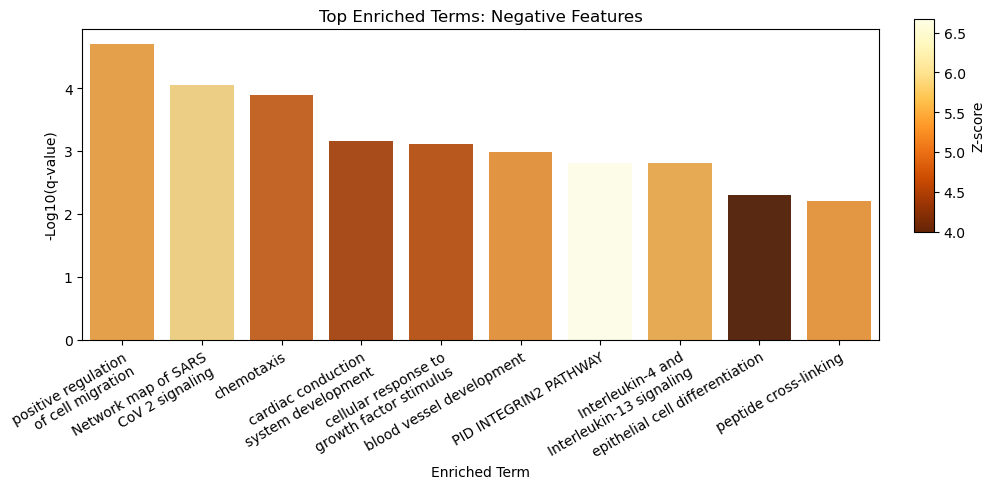

In [117]:
fig, ax = plt.subplots(figsize = (10, 5))

key = 'negative'
top_n = 10
ms = mss[key]
ms_topn = ms.iloc[:top_n, :]

if sort_by == 'zscore':
    color_col = '-Log10(q-value)'
    y_col = 'Z-score'
elif sort_by == 'pval':
    color_col = 'Z-score' 
    y_col = '-Log10(q-value)'
norm = Normalize(vmin=ms_topn[color_col].min(), vmax=ms_topn[color_col].max())
cmap = cm_matplot.get_cmap('YlOrBr_r')
colors = [cmap(norm(val)) for val in ms[color_col]]
cbar_ax = fig.add_axes([0.92, 0.525, 0.02, 0.425])  # [left, bottom, width, height]
# pos = ax.get_position()  # Returns a Bbox object
# cbar_width = 0.02  # Width of the colorbar
# cbar_padding = 0.02  # Space between subplot and colorbar
# cbar_ax = fig.add_axes([pos.x1 + cbar_padding, pos.y0, cbar_width, pos.height])  # [left, bottom, width, height]
colorbar = plt.colorbar(cm_matplot.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
colorbar.set_label(color_col)


sns.barplot(data = ms_topn, x = 'Description', y = y_col, 
            palette = colors, ax = ax)

xlabels = []
for x_label in ax.get_xticklabels():
    xlabels.append(middle_break(x_label._text, len_thresh = 35))

ax.set_xticklabels(xlabels, 
                   rotation=30, va = 'top',
                   ha="right", rotation_mode="anchor")
# ax.get_legend().remove()
ax.set_title('Top Enriched Terms: ' + key.capitalize() + ' Features')
ax.set_xlabel('Enriched Term')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_negativeora.png'), 
            dpi=300, 
            bbox_inches="tight")

In [ ]:
os.path.join(data_path, 'figures', 'joint_feature_negativeora.png')

/tmp/ipykernel_3741602/3011600768.py:15: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  cmap = cm_matplot.get_cmap('YlOrBr_r')
/tmp/ipykernel_3741602/3011600768.py:26: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_3741602/3011600768.py:26: UserWarning: The palette list has more values (20) than needed (10), which may not be intended.
  sns.barplot(data = ms_topn, x = 'Description', y = y_col,
/tmp/ipykernel_3741602/3011600768.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(xlabels,
/tmp/ipykernel_3

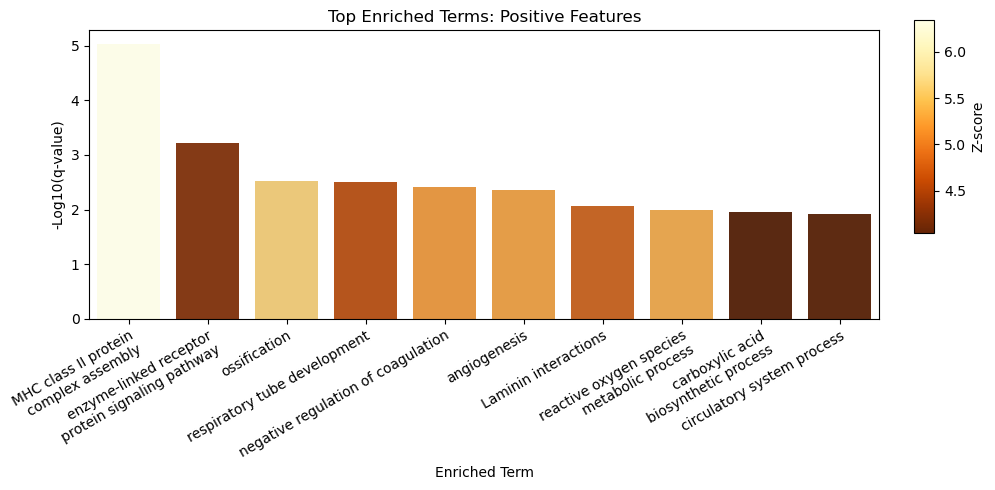

In [118]:
fig, ax = plt.subplots(figsize = (10, 5))

key = 'positive'
top_n = 10
ms = mss[key]
ms_topn = ms.iloc[:top_n, :]

if sort_by == 'zscore':
    color_col = '-Log10(q-value)'
    y_col = 'Z-score'
elif sort_by == 'pval':
    color_col = 'Z-score' 
    y_col = '-Log10(q-value)'
norm = Normalize(vmin=ms_topn[color_col].min(), vmax=ms_topn[color_col].max())
cmap = cm_matplot.get_cmap('YlOrBr_r')
colors = [cmap(norm(val)) for val in ms[color_col]]
cbar_ax = fig.add_axes([0.92, 0.525, 0.02, 0.425])  # [left, bottom, width, height]
# pos = ax.get_position()  # Returns a Bbox object
# cbar_width = 0.02  # Width of the colorbar
# cbar_padding = 0.02  # Space between subplot and colorbar
# cbar_ax = fig.add_axes([pos.x1 + cbar_padding, pos.y0, cbar_width, pos.height])  # [left, bottom, width, height]
colorbar = plt.colorbar(cm_matplot.ScalarMappable(norm=norm, cmap=cmap), cax=cbar_ax)
colorbar.set_label(color_col)


sns.barplot(data = ms_topn, x = 'Description', y = y_col, 
            palette = colors, ax = ax)

xlabels = []
for x_label in ax.get_xticklabels():
    xlabels.append(middle_break(x_label._text, len_thresh = 35))

ax.set_xticklabels(xlabels, 
                   rotation=30, va = 'top',
                   ha="right", rotation_mode="anchor")
# ax.get_legend().remove()
ax.set_title('Top Enriched Terms: ' + key.capitalize() + ' Features')
ax.set_xlabel('Enriched Term')

plt.tight_layout(rect=[0, 0, 0.9, 1])  # Leave space for the colorbar
plt.savefig(os.path.join(data_path, 'figures', 'joint_feature_positiveora.png'), 
            dpi=300, 
            bbox_inches="tight")

In [24]:
# fns = [os.path.join(data_path, 'figures', 'joint_feature_dist.png'), 
# os.path.join(data_path, 'processed', 'rank_ordered_joint_features.csv'),
# os.path.join(data_path, 'figures', 'joint_feature_running_rank.png'),
# os.path.join(data_path, 'figures', 'joint_feature_fisher_trend.png'),
# os.path.join(data_path, 'figures', 'joint_feature_negativeora.png'),
# os.path.join(data_path, 'figures', 'joint_feature_positiveora.png')]

fns = [os.path.join(data_path, 'figures', 'joint_feature_*'), 
      os.path.join(data_path, 'figures', 'overlapping_pearson_running_rank.png')]

for fn in fns:
    cmd = 'scp hmbaghda@satori-login-002.mit.edu:' + fn
    cmd += ' Downloads/figures/.'
    print(cmd)

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/joint_feature_* Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/processed/rank_ordered_joint_features.csv Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/overlapping_pearson_running_rank.png Downloads/figures/.


In [63]:
fns = [os.path.join(data_path, 'figures', 'overlapping_pearson_running_rank.png'),
os.path.join(data_path, 'figures', 'joint_feature_running_rank.png')]

for fn in fns:
    cmd = 'scp hmbaghda@satori-login-002.mit.edu:' + fn
    cmd += ' Downloads/figures/.'
    print(cmd)

scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/overlapping_pearson_running_rank.png Downloads/figures/.
scp hmbaghda@satori-login-002.mit.edu:/nobackup/users/hmbaghda/metastatic_potential/figures/joint_feature_running_rank.png Downloads/figures/.
